<a href="https://colab.research.google.com/github/DiNOV-Tokyo/yolov5/blob/main/DL_torchvsion_DCGAN_car_ex4_SegmentationCarSelect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 現場で使える！　PyTorchPyTorch開発入門


##翔泳社

## 1.1 Google Drive をマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/Colab\ Notebooks
#%mkdir yolo_train
%cd yolo_train

/content/drive/My Drive/Colab Notebooks
/content/drive/My Drive/Colab Notebooks/yolo_train


## 1.2 モジュール読み込み

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
import time

import numpy as np
from tqdm import tqdm
from PIL import Image
import os
import copy

#from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
from torchvision.utils import save_image

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

# GPU/CPUが使えるかどうか確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

PyTorch Version:  1.9.0+cu111
Torchvision Version:  0.10.0+cu111
Setup complete. Using torch 1.9.0+cu111 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


device(type='cuda', index=0)

##DCGANによる画像生成

Stanfrod Cars Datasetから選別した画像をセマンティックセグメンテーションにて車だけを抜き出し、背景を白色にした画像を用いる。

用いる画像ファイルの数を確認。

In [4]:

DIR = 'pspnet_car_data/jpg/'

print(sum(os.path.isfile(os.path.join(DIR, name)) for name in os.listdir(DIR)))

1072


In [5]:
#img_data = ImageFolder("./stanford-car",
img_data = ImageFolder("./pspnet_car_data",
    transform=transforms.Compose([
        transforms.Resize(140),
#        transforms.Resize(160),
        transforms.CenterCrop(128),
        transforms.ToTensor()
]))

#batch_size = 8
batch_size = 16
#batch_size = 64
img_loader = DataLoader(img_data, batch_size=batch_size,
                        shuffle=True)

データの確認

In [ ]:
batch_iterator = iter(img_loader)
imges = next(batch_iterator)
print(imges[0].size())

torch.Size([16, 3, 128, 128])


画像生成モデル

In [6]:
nz = 100
ngf = 32

class GNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8,   
                               4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 8, ngf * 8, 
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 2, ngf,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf, 3,
                               4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        out = self.main(x)
        return out

識別モデル

In [7]:
ndf = 128
ndf = 32

class DNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 2, 0, bias=False),
        )

    def forward(self, x):
        out = self.main(x)
        return out.squeeze()

訓練関数の作成

In [8]:
d = DNet().to("cuda:0")
g = GNet().to("cuda:0")

# Adamのパラメータは元論文の提案値
opt_d = optim.Adam(d.parameters(),
    lr=0.0002, betas=(0.5, 0.999))
opt_g = optim.Adam(g.parameters(),
    lr=0.0002, betas=(0.5, 0.999))

# クロスエントロピーを計算するための補助変数など
ones = torch.ones(batch_size).to("cuda:0")
zeros = torch.zeros(batch_size).to("cuda:0")
loss_f = nn.BCEWithLogitsLoss()

# モニタリング用のz
fixed_z = torch.randn(batch_size, nz, 1, 1).to("cuda:0")

In [9]:
from statistics import mean

def train_dcgan(g, d, opt_g, opt_d, loader):
    # 生成モデル、識別モデルの目的関数の追跡用の配列
    log_loss_g = []
    log_loss_d = []
#    for real_img, _ in loader:
    for real_img, _ in tqdm(loader):
        batch_len = len(real_img)
        
         # 実際の画像をGPUにコピー
        real_img = real_img.to("cuda:0")
        
         # 偽画像を乱数と生成モデルから作る
        z = torch.randn(batch_len, nz, 1, 1).to("cuda:0")
        fake_img = g(z)
        
        # 後で使用するので偽画像の値のみ取り出しておく
        fake_img_tensor = fake_img.detach()
        # 偽画像に対する生成モデルの評価関数を計算する
        out = d(fake_img)

        loss_g = loss_f(out, ones[: batch_len])
        log_loss_g.append(loss_g.item())
        
        # 計算グラフが生成モデルと識別モデルの両方に
        # 依存しているので両者とも勾配をクリアしてから
        # 微分の計算とパラメータ更新を行う
        d.zero_grad(), g.zero_grad()
        loss_g.backward()
        opt_g.step()

        # 実際の画像に対する識別モデルの評価関数を計算
        real_out = d(real_img)

        loss_d_real = loss_f(real_out, ones[: batch_len])
        
        # PyTorchでは同じTensorを含んだ計算グラフに対して
        # 2回backwardを行うことができないので保存してあった
        # Tensorを使用して無駄な計算を省く
        fake_img = fake_img_tensor
        
        # 偽画像に対する識別モデルの評価関数の計算
        fake_out = d(fake_img_tensor)
        loss_d_fake = loss_f(fake_out, zeros[: batch_len])
        
        # 実偽の評価関数の合計値
        loss_d = loss_d_real + loss_d_fake
        log_loss_d.append(loss_d.item())
        
        # 識別モデルの微分計算とパラメータ更新
        d.zero_grad(), g.zero_grad()
        loss_d.backward()
        opt_d.step()

    return mean(log_loss_g), mean(log_loss_d)

訓練開始

In [ ]:

import datetime

for epoch in range(300):
    train_dcgan(g, d, opt_g, opt_d, img_loader)
    print("{} Epoch {}: ".format(datetime.datetime.now(), epoch))
    # 10回の繰り返しごとに学習結果を保存する
    if epoch % 10 == 0:
        # パラメータの保存
        #torch.save(
        #    g.state_dict(),
         #   "cars_train/g_{:03d}.prm".format(epoch),
          #  pickle_protocol=4)
        #torch.save(
         #   d.state_dict(),
          #  "cars_train/d_{:03d}.prm".format(epoch),
           # pickle_protocol=4)
        # モニタリング用のzから生成した画像を保存
        generated_img = g(fixed_z)
        save_image(generated_img,
                   "./pspnet_car_data/b16-{:03d}.jpg".format(epoch))

100%|██████████| 67/67 [04:03<00:00,  3.64s/it]


2021-10-24 05:24:44.260869 Epoch 0: 


100%|██████████| 67/67 [00:45<00:00,  1.47it/s]


2021-10-24 05:25:30.056227 Epoch 1: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 05:26:15.323485 Epoch 2: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 05:27:00.739646 Epoch 3: 


100%|██████████| 67/67 [00:45<00:00,  1.46it/s]


2021-10-24 05:27:46.553571 Epoch 4: 


100%|██████████| 67/67 [00:45<00:00,  1.46it/s]


2021-10-24 05:28:32.384706 Epoch 5: 


100%|██████████| 67/67 [00:46<00:00,  1.46it/s]


2021-10-24 05:29:18.411961 Epoch 6: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 05:30:03.753374 Epoch 7: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 05:30:49.010480 Epoch 8: 


100%|██████████| 67/67 [00:44<00:00,  1.51it/s]


2021-10-24 05:31:33.529304 Epoch 9: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 05:32:18.934405 Epoch 10: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 05:33:04.628290 Epoch 11: 


100%|██████████| 67/67 [00:44<00:00,  1.49it/s]


2021-10-24 05:33:49.604600 Epoch 12: 


100%|██████████| 67/67 [00:44<00:00,  1.52it/s]


2021-10-24 05:34:33.764098 Epoch 13: 


100%|██████████| 67/67 [00:44<00:00,  1.49it/s]


2021-10-24 05:35:18.612742 Epoch 14: 


100%|██████████| 67/67 [00:45<00:00,  1.49it/s]


2021-10-24 05:36:03.717470 Epoch 15: 


100%|██████████| 67/67 [00:44<00:00,  1.49it/s]


2021-10-24 05:36:48.655234 Epoch 16: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 05:37:33.378076 Epoch 17: 


100%|██████████| 67/67 [00:44<00:00,  1.49it/s]


2021-10-24 05:38:18.222338 Epoch 18: 


100%|██████████| 67/67 [00:44<00:00,  1.51it/s]


2021-10-24 05:39:02.482773 Epoch 19: 


100%|██████████| 67/67 [00:44<00:00,  1.52it/s]


2021-10-24 05:39:46.537094 Epoch 20: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 05:40:31.477300 Epoch 21: 


100%|██████████| 67/67 [00:44<00:00,  1.51it/s]


2021-10-24 05:41:15.957843 Epoch 22: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 05:42:00.613677 Epoch 23: 


100%|██████████| 67/67 [00:44<00:00,  1.51it/s]


2021-10-24 05:42:44.986439 Epoch 24: 


100%|██████████| 67/67 [00:44<00:00,  1.51it/s]


2021-10-24 05:43:29.506814 Epoch 25: 


100%|██████████| 67/67 [00:44<00:00,  1.51it/s]


2021-10-24 05:44:13.943142 Epoch 26: 


100%|██████████| 67/67 [00:44<00:00,  1.49it/s]


2021-10-24 05:44:58.918496 Epoch 27: 


100%|██████████| 67/67 [00:45<00:00,  1.49it/s]


2021-10-24 05:45:43.938192 Epoch 28: 


100%|██████████| 67/67 [00:44<00:00,  1.51it/s]


2021-10-24 05:46:28.316839 Epoch 29: 


100%|██████████| 67/67 [00:45<00:00,  1.49it/s]


2021-10-24 05:47:13.379973 Epoch 30: 


100%|██████████| 67/67 [00:45<00:00,  1.47it/s]


2021-10-24 05:47:59.052828 Epoch 31: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 05:48:44.270302 Epoch 32: 


100%|██████████| 67/67 [00:46<00:00,  1.44it/s]


2021-10-24 05:49:30.772656 Epoch 33: 


100%|██████████| 67/67 [00:44<00:00,  1.49it/s]


2021-10-24 05:50:15.753236 Epoch 34: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 05:51:00.422911 Epoch 35: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 05:51:44.970075 Epoch 36: 


100%|██████████| 67/67 [00:44<00:00,  1.51it/s]


2021-10-24 05:52:29.494111 Epoch 37: 


100%|██████████| 67/67 [00:44<00:00,  1.51it/s]


2021-10-24 05:53:13.958907 Epoch 38: 


100%|██████████| 67/67 [00:44<00:00,  1.51it/s]


2021-10-24 05:53:58.436020 Epoch 39: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 05:54:43.024636 Epoch 40: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 05:55:27.915114 Epoch 41: 


100%|██████████| 67/67 [00:46<00:00,  1.45it/s]


2021-10-24 05:56:14.151907 Epoch 42: 


100%|██████████| 67/67 [00:45<00:00,  1.47it/s]


2021-10-24 05:56:59.690711 Epoch 43: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 05:57:44.253626 Epoch 44: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 05:58:28.986573 Epoch 45: 


100%|██████████| 67/67 [00:45<00:00,  1.47it/s]


2021-10-24 05:59:14.716680 Epoch 46: 


100%|██████████| 67/67 [00:46<00:00,  1.43it/s]


2021-10-24 06:00:01.669683 Epoch 47: 


100%|██████████| 67/67 [00:46<00:00,  1.45it/s]


2021-10-24 06:00:47.966272 Epoch 48: 


100%|██████████| 67/67 [00:45<00:00,  1.46it/s]


2021-10-24 06:01:33.761418 Epoch 49: 


100%|██████████| 67/67 [00:45<00:00,  1.46it/s]


2021-10-24 06:02:19.551177 Epoch 50: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 06:03:04.989783 Epoch 51: 


100%|██████████| 67/67 [00:45<00:00,  1.46it/s]


2021-10-24 06:03:50.781219 Epoch 52: 


100%|██████████| 67/67 [00:45<00:00,  1.46it/s]


2021-10-24 06:04:36.751002 Epoch 53: 


100%|██████████| 67/67 [00:45<00:00,  1.47it/s]


2021-10-24 06:05:22.223252 Epoch 54: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 06:06:07.531600 Epoch 55: 


100%|██████████| 67/67 [00:44<00:00,  1.49it/s]


2021-10-24 06:06:52.536615 Epoch 56: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 06:07:37.841420 Epoch 57: 


100%|██████████| 67/67 [00:44<00:00,  1.49it/s]


2021-10-24 06:08:22.673732 Epoch 58: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 06:09:07.997866 Epoch 59: 


100%|██████████| 67/67 [00:45<00:00,  1.47it/s]


2021-10-24 06:09:53.460721 Epoch 60: 


100%|██████████| 67/67 [00:45<00:00,  1.47it/s]


2021-10-24 06:10:39.178343 Epoch 61: 


100%|██████████| 67/67 [00:45<00:00,  1.49it/s]


2021-10-24 06:11:24.307315 Epoch 62: 


100%|██████████| 67/67 [00:44<00:00,  1.49it/s]


2021-10-24 06:12:09.260327 Epoch 63: 


100%|██████████| 67/67 [00:46<00:00,  1.43it/s]


2021-10-24 06:12:56.012155 Epoch 64: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 06:13:41.254713 Epoch 65: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 06:14:25.920925 Epoch 66: 


100%|██████████| 67/67 [00:44<00:00,  1.51it/s]


2021-10-24 06:15:10.416529 Epoch 67: 


100%|██████████| 67/67 [00:45<00:00,  1.49it/s]


2021-10-24 06:15:55.503183 Epoch 68: 


100%|██████████| 67/67 [00:44<00:00,  1.49it/s]


2021-10-24 06:16:40.345505 Epoch 69: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 06:17:24.882398 Epoch 70: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 06:18:09.799081 Epoch 71: 


100%|██████████| 67/67 [00:44<00:00,  1.51it/s]


2021-10-24 06:18:54.110178 Epoch 72: 


100%|██████████| 67/67 [00:44<00:00,  1.51it/s]


2021-10-24 06:19:38.454705 Epoch 73: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 06:20:23.269303 Epoch 74: 


100%|██████████| 67/67 [00:44<00:00,  1.49it/s]


2021-10-24 06:21:08.191295 Epoch 75: 


100%|██████████| 67/67 [00:44<00:00,  1.51it/s]


2021-10-24 06:21:52.605771 Epoch 76: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 06:22:37.178594 Epoch 77: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 06:23:22.446083 Epoch 78: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 06:24:07.013306 Epoch 79: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 06:24:51.613290 Epoch 80: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 06:25:36.576881 Epoch 81: 


100%|██████████| 67/67 [00:45<00:00,  1.47it/s]


2021-10-24 06:26:22.024872 Epoch 82: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 06:27:07.398401 Epoch 83: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 06:27:52.715457 Epoch 84: 


100%|██████████| 67/67 [00:45<00:00,  1.46it/s]


2021-10-24 06:28:38.499438 Epoch 85: 


100%|██████████| 67/67 [00:45<00:00,  1.46it/s]


2021-10-24 06:29:24.382924 Epoch 86: 


100%|██████████| 67/67 [00:47<00:00,  1.42it/s]


2021-10-24 06:30:11.487951 Epoch 87: 


100%|██████████| 67/67 [00:46<00:00,  1.44it/s]


2021-10-24 06:30:58.183497 Epoch 88: 


100%|██████████| 67/67 [00:45<00:00,  1.49it/s]


2021-10-24 06:31:43.302006 Epoch 89: 


100%|██████████| 67/67 [00:45<00:00,  1.47it/s]


2021-10-24 06:32:28.872485 Epoch 90: 


100%|██████████| 67/67 [00:45<00:00,  1.46it/s]


2021-10-24 06:33:14.979645 Epoch 91: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 06:34:00.139000 Epoch 92: 


100%|██████████| 67/67 [00:46<00:00,  1.45it/s]


2021-10-24 06:34:46.338862 Epoch 93: 


100%|██████████| 67/67 [00:46<00:00,  1.45it/s]


2021-10-24 06:35:32.445941 Epoch 94: 


100%|██████████| 67/67 [00:46<00:00,  1.44it/s]


2021-10-24 06:36:19.026432 Epoch 95: 


100%|██████████| 67/67 [00:46<00:00,  1.45it/s]


2021-10-24 06:37:05.193361 Epoch 96: 


100%|██████████| 67/67 [00:45<00:00,  1.46it/s]


2021-10-24 06:37:51.201657 Epoch 97: 


100%|██████████| 67/67 [00:46<00:00,  1.45it/s]


2021-10-24 06:38:37.453366 Epoch 98: 


100%|██████████| 67/67 [00:45<00:00,  1.46it/s]


2021-10-24 06:39:23.431991 Epoch 99: 


100%|██████████| 67/67 [00:47<00:00,  1.43it/s]


2021-10-24 06:40:10.463586 Epoch 100: 


100%|██████████| 67/67 [00:47<00:00,  1.42it/s]


2021-10-24 06:40:57.883641 Epoch 101: 


100%|██████████| 67/67 [00:46<00:00,  1.45it/s]


2021-10-24 06:41:44.225738 Epoch 102: 


100%|██████████| 67/67 [00:46<00:00,  1.44it/s]


2021-10-24 06:42:30.774622 Epoch 103: 


100%|██████████| 67/67 [00:46<00:00,  1.44it/s]


2021-10-24 06:43:17.262902 Epoch 104: 


100%|██████████| 67/67 [00:46<00:00,  1.44it/s]


2021-10-24 06:44:03.844044 Epoch 105: 


100%|██████████| 67/67 [00:46<00:00,  1.45it/s]


2021-10-24 06:44:50.021457 Epoch 106: 


100%|██████████| 67/67 [00:46<00:00,  1.44it/s]


2021-10-24 06:45:36.482714 Epoch 107: 


100%|██████████| 67/67 [00:46<00:00,  1.45it/s]


2021-10-24 06:46:22.672408 Epoch 108: 


100%|██████████| 67/67 [00:46<00:00,  1.45it/s]


2021-10-24 06:47:08.761758 Epoch 109: 


100%|██████████| 67/67 [00:46<00:00,  1.44it/s]


2021-10-24 06:47:55.364443 Epoch 110: 


100%|██████████| 67/67 [00:46<00:00,  1.43it/s]


2021-10-24 06:48:42.326623 Epoch 111: 


100%|██████████| 67/67 [00:46<00:00,  1.44it/s]


2021-10-24 06:49:28.824550 Epoch 112: 


100%|██████████| 67/67 [00:46<00:00,  1.44it/s]


2021-10-24 06:50:15.420197 Epoch 113: 


100%|██████████| 67/67 [00:46<00:00,  1.44it/s]


2021-10-24 06:51:01.864569 Epoch 114: 


100%|██████████| 67/67 [00:45<00:00,  1.47it/s]


2021-10-24 06:51:47.485698 Epoch 115: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 06:52:32.899692 Epoch 116: 


100%|██████████| 67/67 [00:46<00:00,  1.46it/s]


2021-10-24 06:53:18.953726 Epoch 117: 


100%|██████████| 67/67 [00:45<00:00,  1.46it/s]


2021-10-24 06:54:04.879731 Epoch 118: 


100%|██████████| 67/67 [00:46<00:00,  1.45it/s]


2021-10-24 06:54:51.256052 Epoch 119: 


100%|██████████| 67/67 [00:46<00:00,  1.45it/s]


2021-10-24 06:55:37.607000 Epoch 120: 


100%|██████████| 67/67 [00:46<00:00,  1.43it/s]


2021-10-24 06:56:24.780052 Epoch 121: 


100%|██████████| 67/67 [00:47<00:00,  1.42it/s]


2021-10-24 06:57:12.030374 Epoch 122: 


100%|██████████| 67/67 [00:46<00:00,  1.44it/s]


2021-10-24 06:57:58.700663 Epoch 123: 


100%|██████████| 67/67 [00:46<00:00,  1.44it/s]


2021-10-24 06:58:45.265705 Epoch 124: 


100%|██████████| 67/67 [00:46<00:00,  1.44it/s]


2021-10-24 06:59:31.741571 Epoch 125: 


100%|██████████| 67/67 [00:46<00:00,  1.46it/s]


2021-10-24 07:00:17.788561 Epoch 126: 


100%|██████████| 67/67 [00:46<00:00,  1.44it/s]


2021-10-24 07:01:04.242365 Epoch 127: 


100%|██████████| 67/67 [00:46<00:00,  1.44it/s]


2021-10-24 07:01:50.857551 Epoch 128: 


100%|██████████| 67/67 [00:46<00:00,  1.45it/s]


2021-10-24 07:02:37.108726 Epoch 129: 


100%|██████████| 67/67 [00:46<00:00,  1.46it/s]


2021-10-24 07:03:23.181960 Epoch 130: 


100%|██████████| 67/67 [00:44<00:00,  1.51it/s]


2021-10-24 07:04:07.920120 Epoch 131: 


100%|██████████| 67/67 [00:44<00:00,  1.51it/s]


2021-10-24 07:04:52.176778 Epoch 132: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 07:05:36.911453 Epoch 133: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 07:06:21.514443 Epoch 134: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 07:07:06.730522 Epoch 135: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 07:07:52.015361 Epoch 136: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 07:08:37.226157 Epoch 137: 


100%|██████████| 67/67 [00:45<00:00,  1.47it/s]


2021-10-24 07:09:22.879358 Epoch 138: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 07:10:08.062196 Epoch 139: 


100%|██████████| 67/67 [00:45<00:00,  1.47it/s]


2021-10-24 07:10:53.639855 Epoch 140: 


100%|██████████| 67/67 [00:46<00:00,  1.46it/s]


2021-10-24 07:11:39.909091 Epoch 141: 


100%|██████████| 67/67 [00:46<00:00,  1.45it/s]


2021-10-24 07:12:26.239401 Epoch 142: 


100%|██████████| 67/67 [00:46<00:00,  1.44it/s]


2021-10-24 07:13:12.771201 Epoch 143: 


100%|██████████| 67/67 [00:46<00:00,  1.43it/s]


2021-10-24 07:13:59.700533 Epoch 144: 


100%|██████████| 67/67 [00:46<00:00,  1.46it/s]


2021-10-24 07:14:45.717189 Epoch 145: 


100%|██████████| 67/67 [00:46<00:00,  1.44it/s]


2021-10-24 07:15:32.424042 Epoch 146: 


100%|██████████| 67/67 [00:46<00:00,  1.43it/s]


2021-10-24 07:16:19.279343 Epoch 147: 


100%|██████████| 67/67 [00:46<00:00,  1.44it/s]


2021-10-24 07:17:05.883087 Epoch 148: 


100%|██████████| 67/67 [00:46<00:00,  1.44it/s]


2021-10-24 07:17:52.379718 Epoch 149: 


100%|██████████| 67/67 [00:46<00:00,  1.45it/s]


2021-10-24 07:18:38.470217 Epoch 150: 


100%|██████████| 67/67 [00:46<00:00,  1.46it/s]


2021-10-24 07:19:24.761415 Epoch 151: 


100%|██████████| 67/67 [00:46<00:00,  1.45it/s]


2021-10-24 07:20:10.996151 Epoch 152: 


100%|██████████| 67/67 [00:46<00:00,  1.44it/s]


2021-10-24 07:20:57.546601 Epoch 153: 


100%|██████████| 67/67 [00:46<00:00,  1.45it/s]


2021-10-24 07:21:43.916664 Epoch 154: 


100%|██████████| 67/67 [00:45<00:00,  1.46it/s]


2021-10-24 07:22:29.913949 Epoch 155: 


100%|██████████| 67/67 [00:45<00:00,  1.46it/s]


2021-10-24 07:23:15.912858 Epoch 156: 


100%|██████████| 67/67 [00:44<00:00,  1.49it/s]


2021-10-24 07:24:00.769129 Epoch 157: 


100%|██████████| 67/67 [00:43<00:00,  1.56it/s]


2021-10-24 07:24:43.798184 Epoch 158: 


100%|██████████| 67/67 [00:44<00:00,  1.49it/s]


2021-10-24 07:25:28.675625 Epoch 159: 


100%|██████████| 67/67 [00:46<00:00,  1.44it/s]


2021-10-24 07:26:15.316739 Epoch 160: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 07:27:00.791756 Epoch 161: 


100%|██████████| 67/67 [00:44<00:00,  1.49it/s]


2021-10-24 07:27:45.708194 Epoch 162: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 07:28:30.383288 Epoch 163: 


100%|██████████| 67/67 [00:44<00:00,  1.51it/s]


2021-10-24 07:29:14.872471 Epoch 164: 


100%|██████████| 67/67 [00:44<00:00,  1.49it/s]


2021-10-24 07:29:59.748469 Epoch 165: 


100%|██████████| 67/67 [00:45<00:00,  1.49it/s]


2021-10-24 07:30:44.784462 Epoch 166: 


100%|██████████| 67/67 [00:45<00:00,  1.46it/s]


2021-10-24 07:31:30.579598 Epoch 167: 


100%|██████████| 67/67 [00:45<00:00,  1.47it/s]


2021-10-24 07:32:16.127193 Epoch 168: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 07:33:01.414989 Epoch 169: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 07:33:46.601457 Epoch 170: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 07:34:32.105840 Epoch 171: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 07:35:16.778693 Epoch 172: 


100%|██████████| 67/67 [00:44<00:00,  1.49it/s]


2021-10-24 07:36:01.665902 Epoch 173: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 07:36:46.243724 Epoch 174: 


100%|██████████| 67/67 [00:44<00:00,  1.51it/s]


2021-10-24 07:37:30.512348 Epoch 175: 


100%|██████████| 67/67 [00:45<00:00,  1.46it/s]


2021-10-24 07:38:16.334579 Epoch 176: 


100%|██████████| 67/67 [00:45<00:00,  1.47it/s]


2021-10-24 07:39:01.803261 Epoch 177: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 07:39:46.996855 Epoch 178: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 07:40:32.344593 Epoch 179: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 07:41:17.061490 Epoch 180: 


100%|██████████| 67/67 [00:43<00:00,  1.52it/s]


2021-10-24 07:42:01.313181 Epoch 181: 


100%|██████████| 67/67 [00:44<00:00,  1.52it/s]


2021-10-24 07:42:45.339086 Epoch 182: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 07:43:29.991878 Epoch 183: 


100%|██████████| 67/67 [00:44<00:00,  1.52it/s]


2021-10-24 07:44:14.013441 Epoch 184: 


100%|██████████| 67/67 [00:44<00:00,  1.51it/s]


2021-10-24 07:44:58.503577 Epoch 185: 


100%|██████████| 67/67 [00:44<00:00,  1.52it/s]


2021-10-24 07:45:42.570153 Epoch 186: 


100%|██████████| 67/67 [00:44<00:00,  1.49it/s]


2021-10-24 07:46:27.405811 Epoch 187: 


100%|██████████| 67/67 [00:44<00:00,  1.52it/s]


2021-10-24 07:47:11.563683 Epoch 188: 


100%|██████████| 67/67 [00:43<00:00,  1.54it/s]


2021-10-24 07:47:55.200433 Epoch 189: 


100%|██████████| 67/67 [00:43<00:00,  1.54it/s]


2021-10-24 07:48:38.744981 Epoch 190: 


100%|██████████| 67/67 [00:43<00:00,  1.53it/s]


2021-10-24 07:49:22.758201 Epoch 191: 


100%|██████████| 67/67 [00:44<00:00,  1.49it/s]


2021-10-24 07:50:07.643430 Epoch 192: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 07:50:53.071078 Epoch 193: 


100%|██████████| 67/67 [00:43<00:00,  1.53it/s]


2021-10-24 07:51:36.906886 Epoch 194: 


100%|██████████| 67/67 [00:44<00:00,  1.51it/s]


2021-10-24 07:52:21.210904 Epoch 195: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 07:53:05.884357 Epoch 196: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 07:53:50.464610 Epoch 197: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 07:54:35.649008 Epoch 198: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 07:55:20.788736 Epoch 199: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 07:56:05.436574 Epoch 200: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 07:56:50.217843 Epoch 201: 


100%|██████████| 67/67 [00:44<00:00,  1.51it/s]


2021-10-24 07:57:34.543484 Epoch 202: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 07:58:19.091930 Epoch 203: 


100%|██████████| 67/67 [00:43<00:00,  1.52it/s]


2021-10-24 07:59:03.078886 Epoch 204: 


100%|██████████| 67/67 [00:44<00:00,  1.49it/s]


2021-10-24 07:59:47.945966 Epoch 205: 


100%|██████████| 67/67 [00:45<00:00,  1.46it/s]


2021-10-24 08:00:33.794109 Epoch 206: 


100%|██████████| 67/67 [00:44<00:00,  1.51it/s]


2021-10-24 08:01:18.304227 Epoch 207: 


100%|██████████| 67/67 [00:43<00:00,  1.56it/s]


2021-10-24 08:02:01.370552 Epoch 208: 


100%|██████████| 67/67 [00:43<00:00,  1.54it/s]


2021-10-24 08:02:45.001473 Epoch 209: 


100%|██████████| 67/67 [00:43<00:00,  1.55it/s]


2021-10-24 08:03:28.222569 Epoch 210: 


100%|██████████| 67/67 [00:42<00:00,  1.57it/s]


2021-10-24 08:04:11.230457 Epoch 211: 


100%|██████████| 67/67 [00:43<00:00,  1.55it/s]


2021-10-24 08:04:54.347099 Epoch 212: 


100%|██████████| 67/67 [00:43<00:00,  1.55it/s]


2021-10-24 08:05:37.497185 Epoch 213: 


100%|██████████| 67/67 [00:42<00:00,  1.57it/s]


2021-10-24 08:06:20.231979 Epoch 214: 


100%|██████████| 67/67 [00:43<00:00,  1.56it/s]


2021-10-24 08:07:03.311144 Epoch 215: 


100%|██████████| 67/67 [00:43<00:00,  1.54it/s]


2021-10-24 08:07:46.771583 Epoch 216: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 08:08:31.548505 Epoch 217: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 08:09:16.694490 Epoch 218: 


100%|██████████| 67/67 [00:44<00:00,  1.49it/s]


2021-10-24 08:10:01.645063 Epoch 219: 


100%|██████████| 67/67 [00:43<00:00,  1.53it/s]


2021-10-24 08:10:45.354246 Epoch 220: 


100%|██████████| 67/67 [00:44<00:00,  1.51it/s]


2021-10-24 08:11:30.147916 Epoch 221: 


100%|██████████| 67/67 [00:45<00:00,  1.47it/s]


2021-10-24 08:12:15.855605 Epoch 222: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 08:13:00.499395 Epoch 223: 


100%|██████████| 67/67 [00:44<00:00,  1.51it/s]


2021-10-24 08:13:44.931404 Epoch 224: 


100%|██████████| 67/67 [00:43<00:00,  1.53it/s]


2021-10-24 08:14:28.655869 Epoch 225: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 08:15:13.416032 Epoch 226: 


100%|██████████| 67/67 [00:44<00:00,  1.49it/s]


2021-10-24 08:15:58.412659 Epoch 227: 


100%|██████████| 67/67 [00:44<00:00,  1.52it/s]


2021-10-24 08:16:42.636579 Epoch 228: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 08:17:28.049622 Epoch 229: 


100%|██████████| 67/67 [00:45<00:00,  1.46it/s]


2021-10-24 08:18:14.048041 Epoch 230: 


100%|██████████| 67/67 [00:44<00:00,  1.51it/s]


2021-10-24 08:18:58.803145 Epoch 231: 


100%|██████████| 67/67 [00:44<00:00,  1.51it/s]


2021-10-24 08:19:43.194988 Epoch 232: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 08:20:27.830724 Epoch 233: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 08:21:12.419402 Epoch 234: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 08:21:57.186851 Epoch 235: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 08:22:42.565549 Epoch 236: 


100%|██████████| 67/67 [00:46<00:00,  1.46it/s]


2021-10-24 08:23:28.596027 Epoch 237: 


100%|██████████| 67/67 [00:45<00:00,  1.46it/s]


2021-10-24 08:24:14.360804 Epoch 238: 


100%|██████████| 67/67 [00:45<00:00,  1.49it/s]


2021-10-24 08:24:59.436459 Epoch 239: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 08:25:44.857393 Epoch 240: 


100%|██████████| 67/67 [00:45<00:00,  1.49it/s]


2021-10-24 08:26:30.228714 Epoch 241: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 08:27:14.998499 Epoch 242: 


100%|██████████| 67/67 [00:45<00:00,  1.49it/s]


2021-10-24 08:28:00.046304 Epoch 243: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 08:28:44.689588 Epoch 244: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 08:29:30.111138 Epoch 245: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 08:30:15.473612 Epoch 246: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 08:31:00.101145 Epoch 247: 


100%|██████████| 67/67 [00:44<00:00,  1.49it/s]


2021-10-24 08:31:45.008953 Epoch 248: 


100%|██████████| 67/67 [00:44<00:00,  1.51it/s]


2021-10-24 08:32:29.327776 Epoch 249: 


100%|██████████| 67/67 [00:45<00:00,  1.46it/s]


2021-10-24 08:33:15.279965 Epoch 250: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 08:34:00.648226 Epoch 251: 


100%|██████████| 67/67 [00:45<00:00,  1.49it/s]


2021-10-24 08:34:45.729358 Epoch 252: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 08:35:30.558646 Epoch 253: 


100%|██████████| 67/67 [00:44<00:00,  1.49it/s]


2021-10-24 08:36:15.459955 Epoch 254: 


100%|██████████| 67/67 [00:46<00:00,  1.46it/s]


2021-10-24 08:37:01.512494 Epoch 255: 


100%|██████████| 67/67 [00:46<00:00,  1.45it/s]


2021-10-24 08:37:47.699565 Epoch 256: 


100%|██████████| 67/67 [00:44<00:00,  1.49it/s]


2021-10-24 08:38:32.612705 Epoch 257: 


100%|██████████| 67/67 [00:44<00:00,  1.51it/s]


2021-10-24 08:39:17.042413 Epoch 258: 


100%|██████████| 67/67 [00:44<00:00,  1.50it/s]


2021-10-24 08:40:01.730373 Epoch 259: 


100%|██████████| 67/67 [00:43<00:00,  1.53it/s]


2021-10-24 08:40:45.651367 Epoch 260: 


100%|██████████| 67/67 [00:44<00:00,  1.52it/s]


2021-10-24 08:41:29.981266 Epoch 261: 


100%|██████████| 67/67 [00:44<00:00,  1.51it/s]


2021-10-24 08:42:14.337811 Epoch 262: 


100%|██████████| 67/67 [00:44<00:00,  1.49it/s]


2021-10-24 08:42:59.183693 Epoch 263: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 08:43:44.575621 Epoch 264: 


100%|██████████| 67/67 [00:46<00:00,  1.45it/s]


2021-10-24 08:44:30.910725 Epoch 265: 


100%|██████████| 67/67 [00:46<00:00,  1.44it/s]


2021-10-24 08:45:17.623812 Epoch 266: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 08:46:02.982451 Epoch 267: 


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


2021-10-24 08:46:48.307236 Epoch 268: 


100%|██████████| 67/67 [00:45<00:00,  1.46it/s]


2021-10-24 08:47:34.207837 Epoch 269: 


100%|██████████| 67/67 [00:45<00:00,  1.46it/s]


2021-10-24 08:48:20.139097 Epoch 270: 


100%|██████████| 67/67 [00:45<00:00,  1.46it/s]


2021-10-24 08:49:06.304380 Epoch 271: 


100%|██████████| 67/67 [00:46<00:00,  1.44it/s]


2021-10-24 08:49:52.784514 Epoch 272: 


100%|██████████| 67/67 [00:46<00:00,  1.43it/s]


2021-10-24 08:50:39.682178 Epoch 273: 


100%|██████████| 67/67 [00:46<00:00,  1.43it/s]


2021-10-24 08:51:26.448305 Epoch 274: 


100%|██████████| 67/67 [00:46<00:00,  1.44it/s]


2021-10-24 08:52:12.846361 Epoch 275: 


100%|██████████| 67/67 [00:46<00:00,  1.44it/s]


2021-10-24 08:52:59.297302 Epoch 276: 


100%|██████████| 67/67 [00:46<00:00,  1.44it/s]


2021-10-24 08:53:45.851532 Epoch 277: 


100%|██████████| 67/67 [00:46<00:00,  1.45it/s]


2021-10-24 08:54:32.209228 Epoch 278: 


100%|██████████| 67/67 [00:46<00:00,  1.44it/s]


2021-10-24 08:55:18.777165 Epoch 279: 


100%|██████████| 67/67 [00:46<00:00,  1.45it/s]


2021-10-24 08:56:05.107246 Epoch 280: 


100%|██████████| 67/67 [00:46<00:00,  1.43it/s]


2021-10-24 08:56:52.100560 Epoch 281: 


100%|██████████| 67/67 [00:46<00:00,  1.44it/s]


2021-10-24 08:57:38.729128 Epoch 282: 


100%|██████████| 67/67 [00:46<00:00,  1.45it/s]


2021-10-24 08:58:25.082671 Epoch 283: 


100%|██████████| 67/67 [00:46<00:00,  1.45it/s]


2021-10-24 08:59:11.331853 Epoch 284: 


 12%|█▏        | 8/67 [00:05<00:41,  1.44it/s]

結果の表示

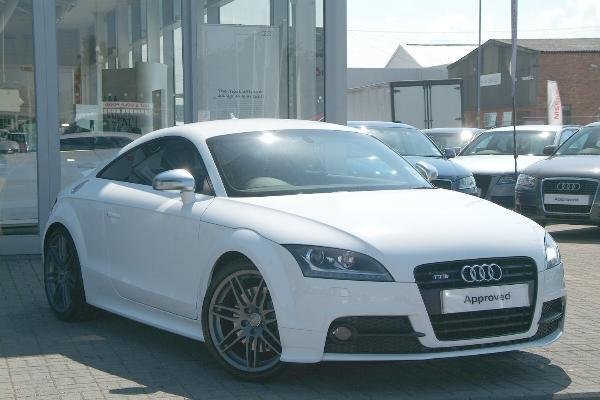

In [ ]:
from IPython.display import Image,display_jpeg
#display_jpeg(Image('cars_train/080.jpg'))
display_jpeg(Image('stanford-car/jpg/00001.jpg'))

In [ ]:
!ls -all